1-1) EDA 및 데이터 전처리 (시각화 및 통계량) (5점)

1-2) Train / Valid / Test set으로 데이터 분할하고 시각화

1-3) 2차 교호작용항까지 고려한 회귀분석 수행 및 변수 선택 과정

1-4) 벌점, 앙상블을 포함해서 그 외 모형에 적합한 기계학습 모델을 3가지 생성하고 모델 최적화 과정 (MSE,MAPE, R2를 제시해야함)

In [1]:
### 전처리
import numpy as np
import pandas as pd
import datetime

### 진행률표기
from tqdm import tqdm

### 그래프
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumBarunGothic')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

###  머신러닝, 통계
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
#import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [2]:
import os
print(os.getcwd())

/content


In [3]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [4]:
cd MyDrive/My\ Drive

/content/MyDrive/My Drive


In [5]:
cd Colab\ Notebooks

/content/MyDrive/My Drive/Colab Notebooks


In [6]:
cd data

/content/MyDrive/My Drive/Colab Notebooks/data


In [7]:
df= pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA 및 전처리 (시각화 및 통계량)

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [ ]:
#결측값 처리
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [ ]:
 #exposure, fintype2에서 지하실 관련 결측값이 1개 더 생기는 문제가 있음
 df[(df['BsmtExposure'].isnull()) & ~(df['BsmtCond'].isnull())] 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,...,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


In [ ]:
## Electrical 결측값 1개
df[df['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,...,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [ ]:
### 결측값 처리
df['Alley'].fillna('NoAlley', inplace = True)
df['MasVnrType'].fillna('None'. inplace = True) # 굳이 삭제할 필요가 없음. 이게 별로 유의미하지 않은 변수일 수도 있으니까
df['MasVnrArea'].fillna(0, inplace = True)
df['BsmtQual'].fillna('None', inplace = True)  ## basement 변수가 어떤 역할을 하는지 알아야됨; 일반적으로는 지하실 높이가 낮으면 값도 싸겠지만 실제로도 그럴까?
df['BsmtCond'].fillna('None', inplace = True)
df['BsmtFinType1', 'BsmtFinType2'].fillna('None', inplace = True)
# ID 949번은 그냥 드롭하자.. 귀찮다.. Electrical 변수가 없는 1380번도 드롭
df = df[(df['Id']!=949) & (df['Id']!=1380)]
df['BsmtFinType1', 'BsmtFinType2'].fillna('None', inplace = True)
df['FireplaceQu'].fillna('None', inplace = True)
### garage 관련 변수들 어케 처리하지? 

## 이건 결측값부터 보면 답 없고 변수선택부터 해야됨.

In [ ]:
## 뭔 통계량을 보라는거지? 일단 변수들 상태를 분포를 대강 확인해보자
df.describe()

## 음 표준편차가 들쑥날쑥한 걸 보니 특정 모델을 사용할 때는 standization을 하고 들어가야겠다는 생각이 드는군

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


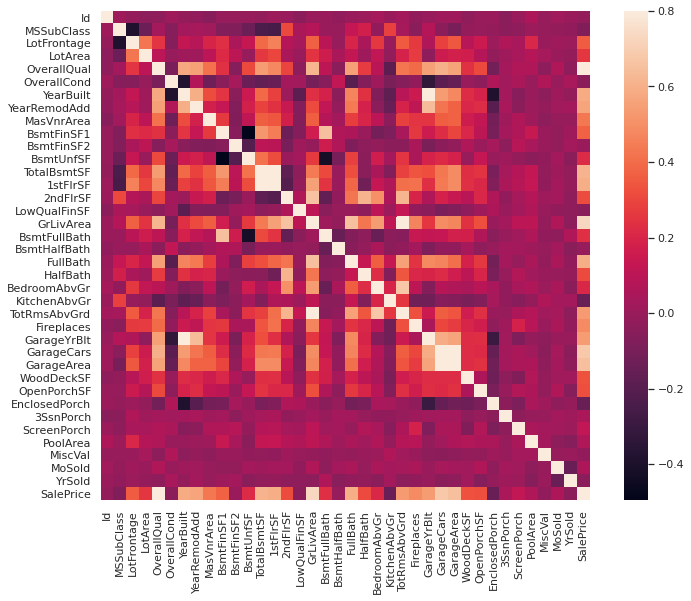

In [13]:
## correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

##Y 변수인 SalesPrice와 관계된 변수들을 찾아보자.
## 그리고 상관성이 엄청 높게 나온 X 변수들이 있다. 얘네들은 모델링할 때 변수 하나만 써야하니까 따로 빼서 확인해둠
## 1stFlrSF, totalBsmtSF/ TotRmsAbvGrd, GrLivArea / GarageYrBlt, YearBuilt

## correlation이 0.6을 넘기는 X변수들이 많다. 이래서 문제에서 교호작용항을 고려하라고 했구나~

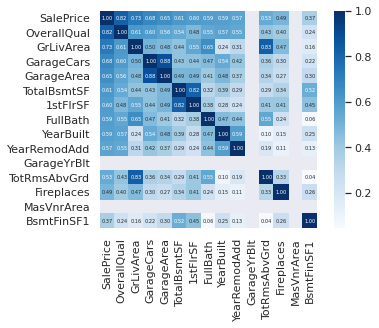

<Figure size 2880x1440 with 0 Axes>

In [14]:
k = 15  #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 
# nlargest => correlation matrix에서 'SalesPrice' column에 해당하는 가장 큰 수 10개 뽑기
cm = np.corrcoef(df[cols].values.T) #cols를 가장 큰 수의 row index로 받아와서 다시 numpy correlation형식으로 만들고 그래프를 그려줌
## 여기서 T는 굳이 필요 없는데.. transpose 안하고 values로만 넣어도 그대로 나옴. 대체 코드에 왜 넣었을까?
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5}, yticklabels=cols.values, xticklabels=cols.values, cmap = 'Blues')
plt.figure(figsize=(40,20))
plt.show()

대부분이 Y 변수와 유의하게 나오는데?
하긴.. 집값이니까 당연히 대부분의 변수들이 집값과 바로 연결될 듯.
여기서 15번째로 유의하게 나온 BsmtFinSF1은 제외해야겠다. 
어차피 1stFlrSF로 80%가 설명될 수 있는 변수이기 때문에 굳이 같이 들어갈 필요가 없음. 
지금 뽑은 14개만 가지고 해보자

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



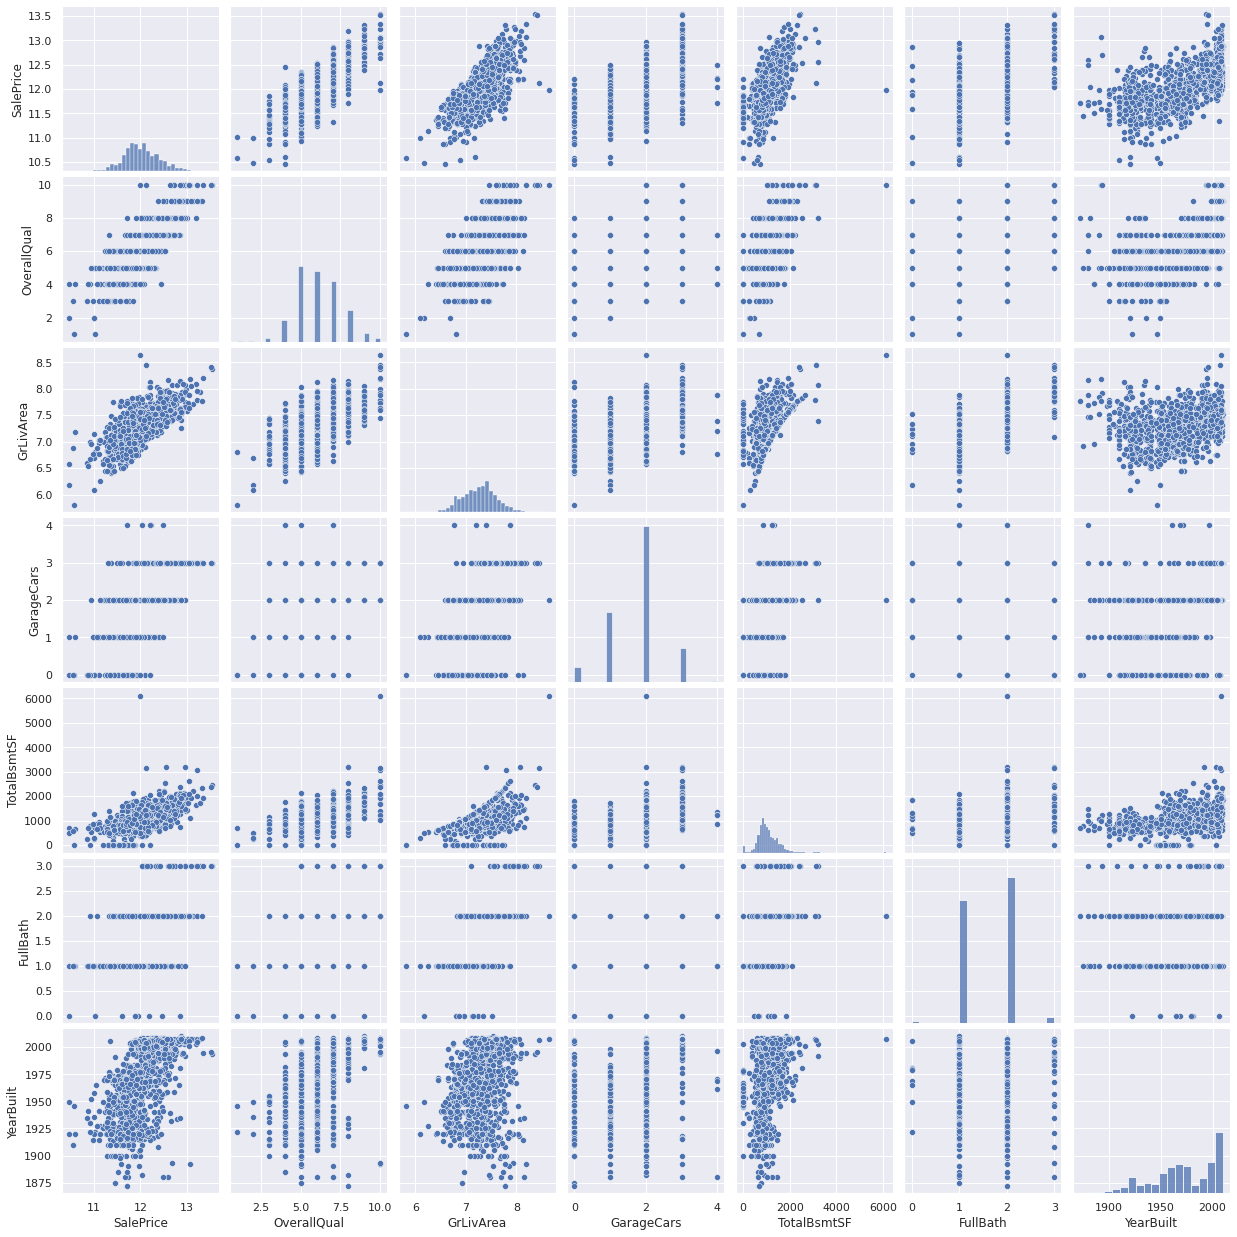

In [11]:
### scatter plot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [8]:
## positive skewed graph는 log를 씌워서 처리
df['SalePrice'] = df['SalePrice'].apply(lambda x: np.log(x))
df['GrLivArea'] = df['GrLivArea'].apply(lambda x: np.log(x))

# 2) Train, Validation Set 나누고 시각화

In [15]:
## 뭔 시각화를 해야하지?
## test set은 이미 나눠져있는 거나 다름 없으니까 train set과 validation set만 나눠줘야겠다.

## independent variable이 범주형이면 stratified split을 했겠지만, 이 경우에는 고려해줄 필요가 없음. 바로 나누기
### 아까 correlation 컸던 변수들 다 데려와서 때려박어
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# 근데 아까 봤던 것처럼 Bsmt 얘는 빼야지
x = df[cols]
x.drop(['BsmtFinSF1', 'SalePrice'], axis = 1, inplace = True)
y = df[['SalePrice']]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
total = x_train.isnull().sum().sort_values(ascending=False)
percent = (x_train.isnull().sum()/x_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
GarageYrBlt,49,0.047945
MasVnrArea,5,0.004892
Fireplaces,0,0.000000
TotRmsAbvGrd,0,0.000000
YearRemodAdd,0,0.000000
YearBuilt,0,0.000000
FullBath,0,0.000000
1stFlrSF,0,0.000000
TotalBsmtSF,0,0.000000
GarageArea,0,0.000000


In [17]:
x_train['GarageYrBlt'].fillna(0, inplace = True) ## Garage, 현관어쩌고가 없는 건 0으로 치면 될듯
x_train['MasVnrArea'].fillna(0, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
x_val['GarageYrBlt'].fillna(0, inplace = True) ## Garage, 현관어쩌고가 없는 건 0으로 치면 될듯
x_val['MasVnrArea'].fillna(0, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 2차 교호작용항까지 고려한 회귀분석 시행 및 변수선택 구현

구글링하다보니까 이 사람 코드를 그대로 따라하면 되는 듯. 구현을 정말 잘 해 놓음
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [ ]:
### 교호작용 고려한 linear regression
##원래... standirdization 하고 시작해야 되는데... 했다고 치자 시간이 없으니까


In [ ]:
## 데이터 수가 너무 적으니까 k fold CV를 사용
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [18]:
### 2차 교호작용항 회귀분석 코드

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
poly_model = make_pipeline(PolynomialFeatures(interaction_only = True), LinearRegression())
# interaction_only 파라미터는 다항 말고 교호작용만 고려한 모델을 만들어줌

In [23]:
from sklearn import pipeline
poly_model2 = pipeline.Pipeline(steps = [('t', PolynomialFeatures(interaction_only = True)), ('m', LinearRegression())])

In [ ]:
### sklearn feature_selecton 찾아보기. 

In [24]:
## 그런데 변수선택을 어떻게 구현하지? 그것이 문제로다..
## 엥? 찾다보니 파이썬에서 변수선택하는 패키지가 존재한다.
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from numpy import ravel

y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

sfs1 = sfs(poly_model2,
           #k_features=None, # 선택 개수 설정 가능
           forward=True, # forward와 backward 두 개 가능
           floating=False,
           verbose=2,
           scoring='r2',
           cv=5)  ## cv 는 크로스밸리데이션 수
# Perform SFFS
sfs1 = sfs1.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s finished

[2021-01-24 11:28:10] Features: 1/1 -- score: 0.6637969764449296

In [ ]:
### 선택된 feature 확인하기
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 3, 4, 8, 9, 12]


In [ ]:
x_train.columns[feat_cols]

Index(['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt',
       'YearRemodAdd', 'Fireplaces'],
      dtype='object')

# 4) 벌점, 앙상블을 포함해서 그 외 모형에 적합한 기계학습 모델을 3가지 생성하고 모델 최적화 과정 (MSE,MAPE, R2를 제시해야함)

In [ ]:
## (앙상블 - xgboost) 
#GridSearchCV를 써서 하이퍼파라미터를 구해야 하지만 저는 돌릴 시간이 안 나올 것 같아서 kaggle에 있는 하이퍼파라미터를 그대로 가져왔어요

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
## (벌점 - Elastic Net Regression)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
## 코드에 돌려!
model1 = model_xgb.fit(x_train, y_train)
model2 = ENet.fit(x_train, y_train)

In [ ]:
## MSE 계산 코드
from sklearn.metrics import mean_squared_error
model1